In [1]:
#!unzip -q '/content/LungTumorDetectionAndSegmentation.zip' -d '/content/dataset'

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.2 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing

In [3]:
import os
import shutil
from pathlib import Path
from PIL import Image

In [4]:
def convert_to_yolo_format(xmin, ymin, xmax, ymax, img_width, img_height):
    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return [0, x_center, y_center, width, height]

In [5]:
def process_split(split):
    image_dir = f"/kaggle/input/dataset/{split}/images"
    label_dir = f"/kaggle/input/dataset/{split}/detections"

    out_image_dir = f"/kaggle/working/dataset/images/{split}"
    out_label_dir = f"/kaggle/working/dataset/labels/{split}"

    os.makedirs(out_image_dir, exist_ok=True)
    os.makedirs(out_label_dir, exist_ok=True)

    for subject in os.listdir(image_dir):

        subject_image_path = os.path.join(image_dir, subject)
        subject_label_path = os.path.join(label_dir, subject)

        for img_file in os.listdir(subject_image_path):
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(subject_image_path, img_file)
            label_file = img_file.rsplit(".", 1)[0] + ".txt"
            label_path = os.path.join(subject_label_path, label_file)

            with Image.open(img_path) as img:
                w, h = img.size

            new_img_name = f"{subject}_{img_file}"
            new_img_path = os.path.join(out_image_dir, new_img_name)
            shutil.copy(img_path, new_img_path)


            yolo_lines = []
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f:

                        vals = list(map(float, line.strip().replace(',', ' ').split()))
                        if len(vals) != 4:
                            continue
                        xmin, ymin, xmax, ymax = vals
                        yolo_vals = convert_to_yolo_format(xmin, ymin, xmax, ymax, w, h)
                        yolo_lines.append(" ".join(map(str, yolo_vals)))

            out_label_path = os.path.join(out_label_dir, new_img_name.rsplit(".", 1)[0] + ".txt")
            with open(out_label_path, "w") as f:
                f.write("\n".join(yolo_lines))


In [6]:
for split in ['train', 'val']:
    process_split(split)

In [7]:
with open("lung_tumor.yaml", "w") as f:
    f.write("""train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/val
nc: 1
names: ['tumor']
""")

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or yolov8s.pt

results=model.train(data='lung_tumor.yaml', epochs=50, imgsz=1024,patience=10,lr0=1e-4,close_mosaic=10,box=0.05,cls=0.5,device=0)
print(results)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 113MB/s]


Ultralytics 8.3.143 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.05, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=lung_tumor.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

100%|██████████| 755k/755k [00:00<00:00, 27.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 118MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 908.5±402.9 MB/s, size: 38.2 KB)


train: Scanning /kaggle/working/dataset/labels/train... 1832 images, 285 backgrounds, 0 corrupt: 100%|██████████| 1832/1832 [00:01<00:00, 1354.34it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 649.1±337.4 MB/s, size: 33.0 KB)


val: Scanning /kaggle/working/dataset/labels/val... 98 images, 20 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<00:00, 1104.42it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.81G    0.01246      5.839      1.548         12       1024: 100%|██████████| 115/115 [00:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all         98         86      0.552      0.151      0.198     0.0822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.97G    0.01276      3.388      1.596          7       1024: 100%|██████████| 115/115 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all         98         86      0.179     0.0233     0.0263     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.99G     0.0124      2.269      1.608         15       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all         98         86      0.766      0.343      0.462        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.01G     0.0122      1.797      1.571         16       1024: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         98         86      0.466      0.349       0.35       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.02G    0.01227      1.644      1.605         11       1024: 100%|██████████| 115/115 [00:41<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         98         86      0.417      0.244       0.27      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.04G    0.01151      1.461      1.519         18       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all         98         86       0.66      0.477      0.511      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.06G     0.0115      1.352      1.524          7       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all         98         86      0.764      0.489      0.566      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.08G    0.01122      1.293      1.492          7       1024: 100%|██████████| 115/115 [00:41<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all         98         86      0.825      0.581      0.584      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.09G    0.01134      1.293      1.507         13       1024: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         98         86      0.813      0.593      0.664      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.11G    0.01108      1.197      1.486         10       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all         98         86      0.775       0.57      0.588      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.13G    0.01089      1.166      1.445          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all         98         86      0.858       0.56       0.62      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.15G    0.01077      1.092       1.45          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         98         86       0.84      0.674      0.663      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       6.2G    0.01037      1.011       1.41          5       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         98         86      0.741      0.488      0.575       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.21G    0.01005       0.98      1.379          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all         98         86      0.904      0.663      0.718      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.22G   0.009973     0.9691       1.36         12       1024: 100%|██████████| 115/115 [00:41<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         98         86       0.85       0.66      0.686      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.25G   0.009877     0.9252      1.345         14       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all         98         86      0.899       0.57       0.64      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.27G   0.009829     0.9055      1.345         12       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all         98         86      0.955      0.605      0.653      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.28G    0.00959     0.8846      1.328         11       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all         98         86      0.882      0.523      0.593      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.29G   0.009387     0.8672      1.305          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all         98         86      0.871      0.488      0.588      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.32G   0.009253     0.8529      1.306         14       1024: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all         98         86        0.9      0.547      0.622      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.34G   0.009121     0.8219      1.284          6       1024: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all         98         86      0.811       0.64      0.689       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.35G   0.009298      0.827      1.293          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all         98         86      0.894      0.605      0.696      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.36G   0.009204     0.7997       1.28         10       1024: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         98         86      0.888      0.593      0.671      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.39G   0.008883     0.7667      1.249          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all         98         86      0.865       0.57      0.646      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       6.4G   0.008639     0.7396      1.232          9       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all         98         86      0.922      0.547      0.656       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.42G   0.008822      0.744      1.255         14       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all         98         86      0.788      0.606      0.645      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.43G   0.008778     0.7464      1.246         19       1024: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all         98         86      0.933      0.581      0.651       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.46G   0.008587     0.7328      1.233          8       1024: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all         98         86      0.842      0.558      0.607      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.47G   0.008613      0.718      1.239         10       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         98         86      0.809      0.592       0.62      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.49G   0.008688     0.7306      1.231         10       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         98         86      0.774      0.535      0.575      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       6.5G   0.008238     0.6916      1.196         16       1024: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all         98         86      0.925      0.581      0.627      0.297
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



33 epochs completed in 0.391 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


                   all         98         86      0.811       0.64      0.689      0.389


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 6.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea73cbaed90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.0


image 1/1 /kaggle/input/dataset/val/images/Subject_57/209.png: 1024x1024 1 tumor, 13.2ms
Speed: 4.7ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)


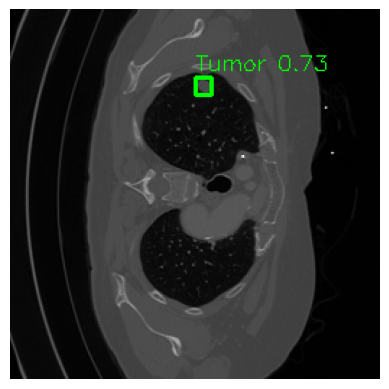

In [12]:

import cv2
import matplotlib.pyplot as plt

# Load trained model
model = YOLO('runs/detect/train/weights/best.pt')

def infer_image(img_path, conf=0.3):    
    results = model(img_path, conf=conf)
    boxes = results[0].boxes
    image = cv2.imread(img_path)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0].item()
        label = box.cls[0].item()
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(image, f"Tumor {conf:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return image, boxes

# Example usage
img, boxes = infer_image('/kaggle/input/dataset/val/images/Subject_57/209.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [15]:
def draw_box(img, box, label, color):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

ground truth:-  130.0 47.0 140.0 58.0
predicted boundry box:-  tensor([[127.2213,  45.5858, 140.6561,  58.3609]], device='cuda:0')


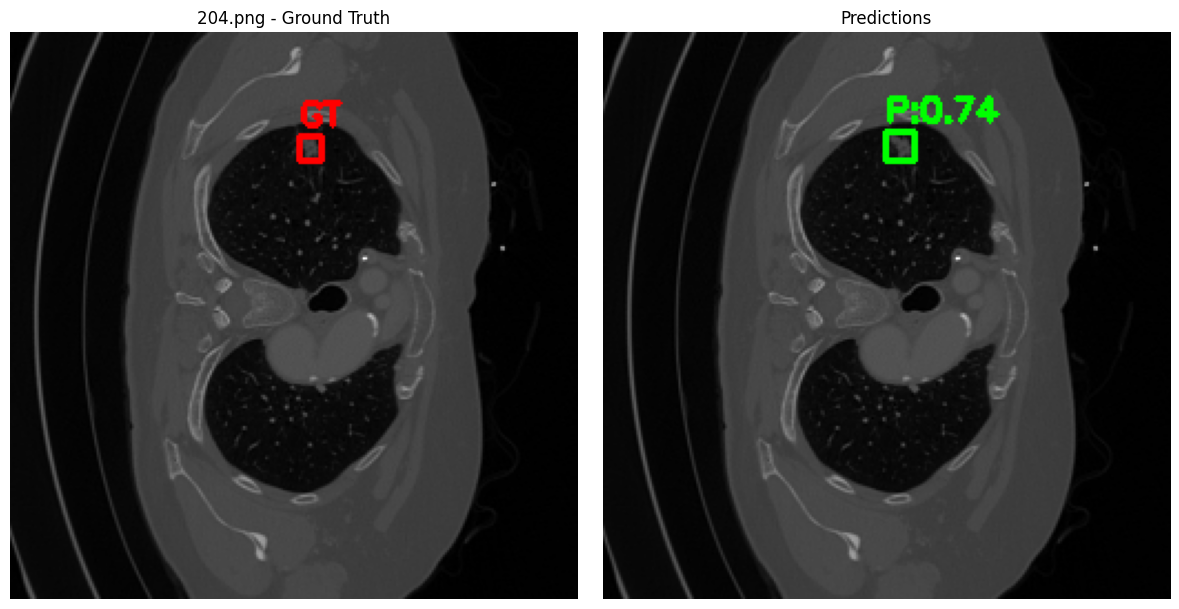

ground truth:-  131.0 51.0 138.0 60.0
predicted boundry box:-  tensor([[130.6509,  50.3332, 138.2341,  59.2116]], device='cuda:0')
predicted boundry box:-  tensor([[209.9814, 132.2928, 217.6237, 141.0305]], device='cuda:0')


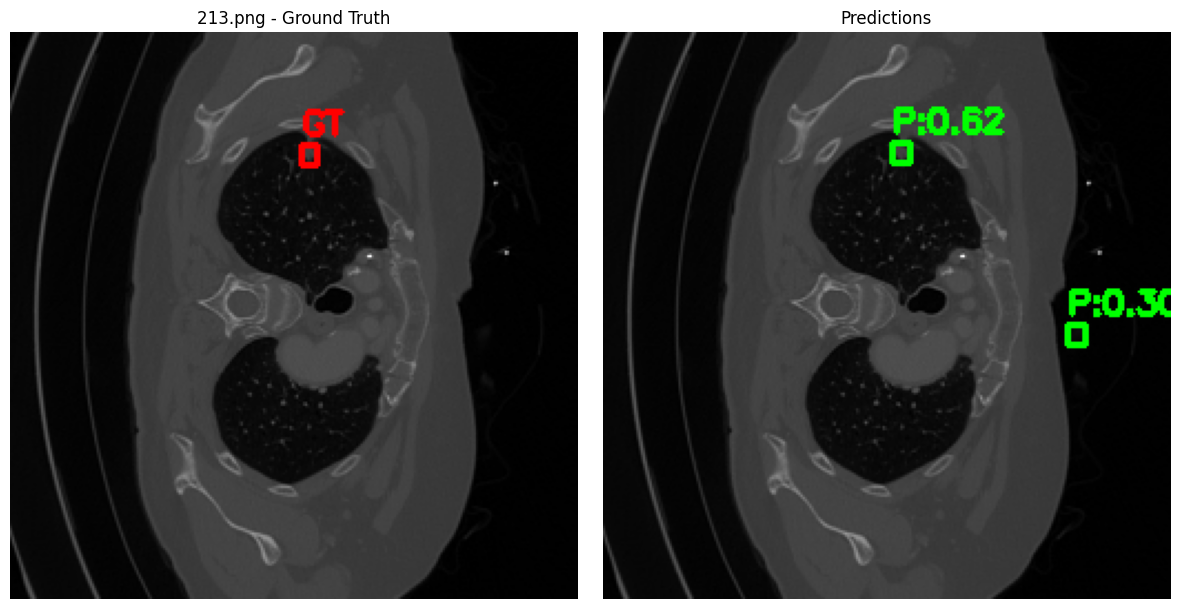

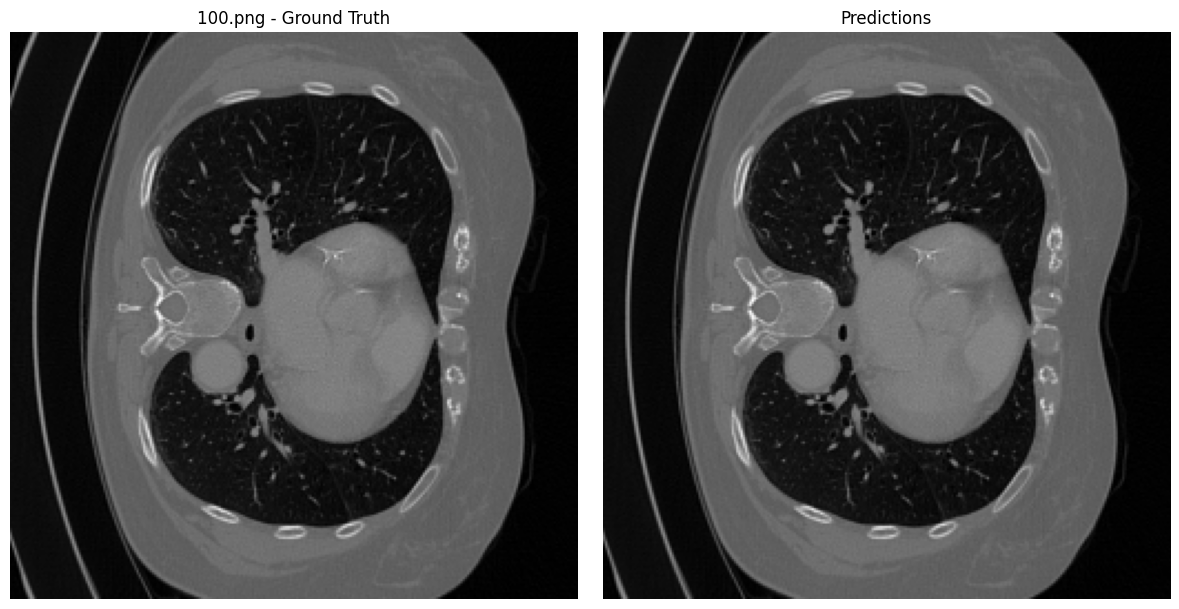

ground truth:-  131.0 50.0 141.0 58.0
predicted boundry box:-  tensor([[129.0647,  48.9946, 140.4786,  58.7808]], device='cuda:0')


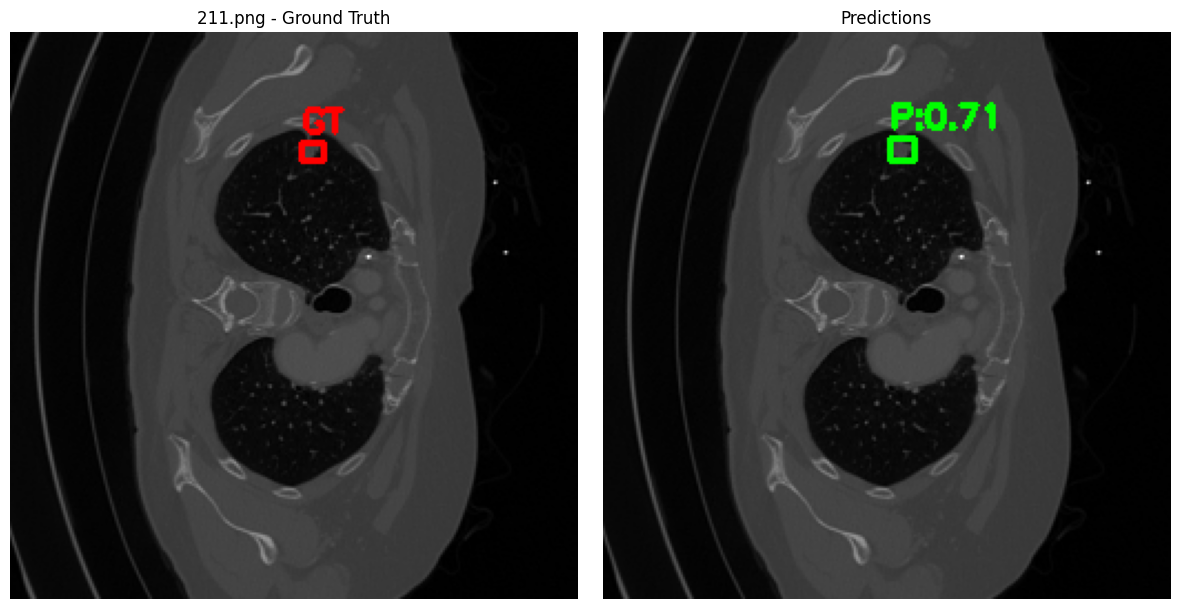

ground truth:-  129.0 48.0 140.0 60.0
predicted boundry box:-  tensor([[128.5542,  47.7645, 139.8789,  59.3626]], device='cuda:0')


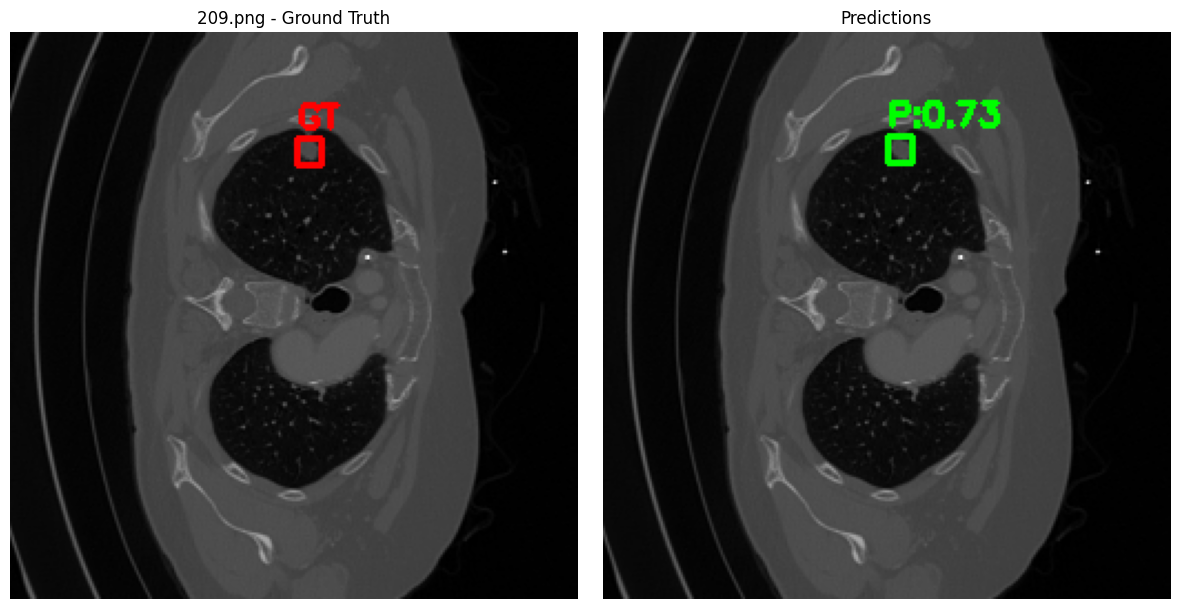

ground truth:-  132.0 52.0 133.0 53.0
ground truth:-  132.0 56.0 136.0 59.0
predicted boundry box:-  tensor([[130.0354,  51.9357, 137.8806,  60.0132]], device='cuda:0')


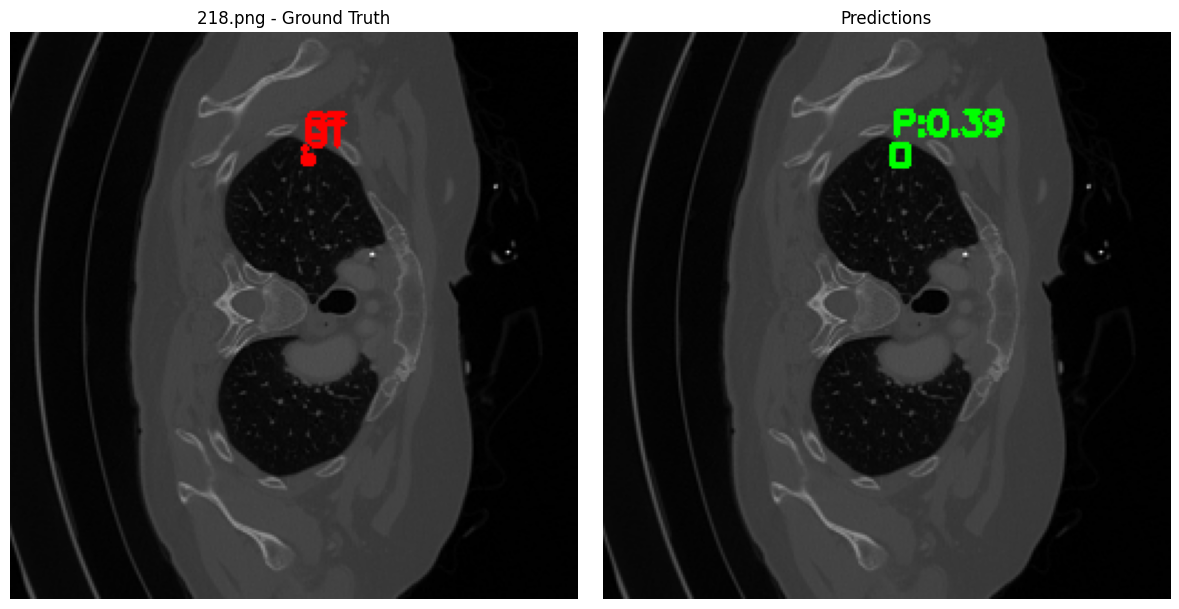

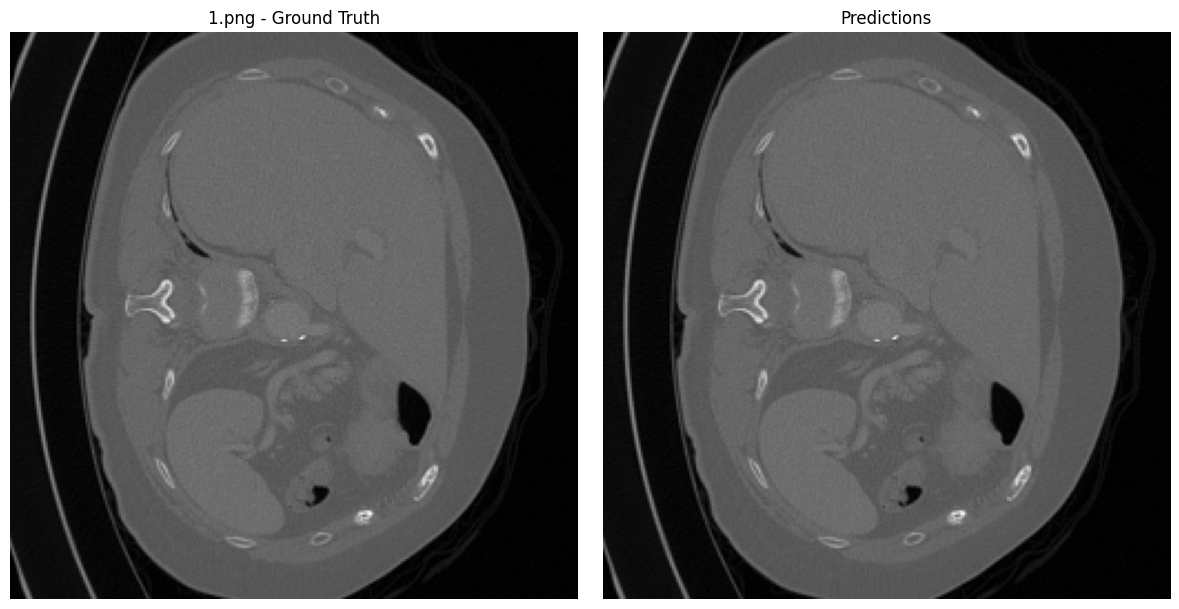

ground truth:-  132.0 47.0 134.0 48.0
ground truth:-  132.0 51.0 138.0 60.0
predicted boundry box:-  tensor([[130.7500,  50.3275, 138.1866,  60.5740]], device='cuda:0')


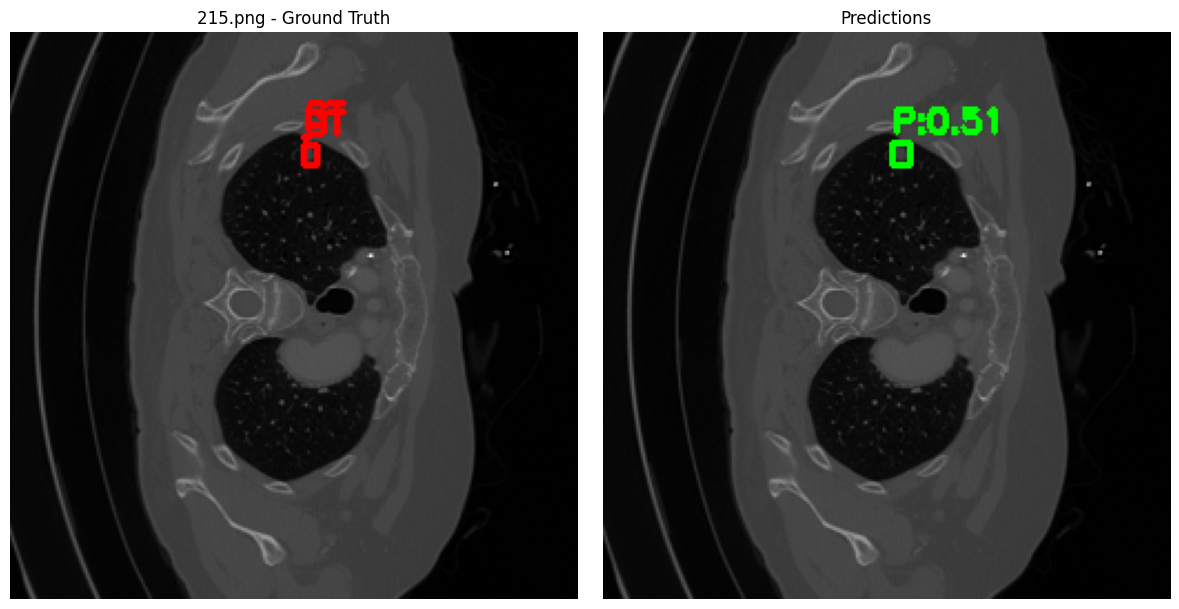

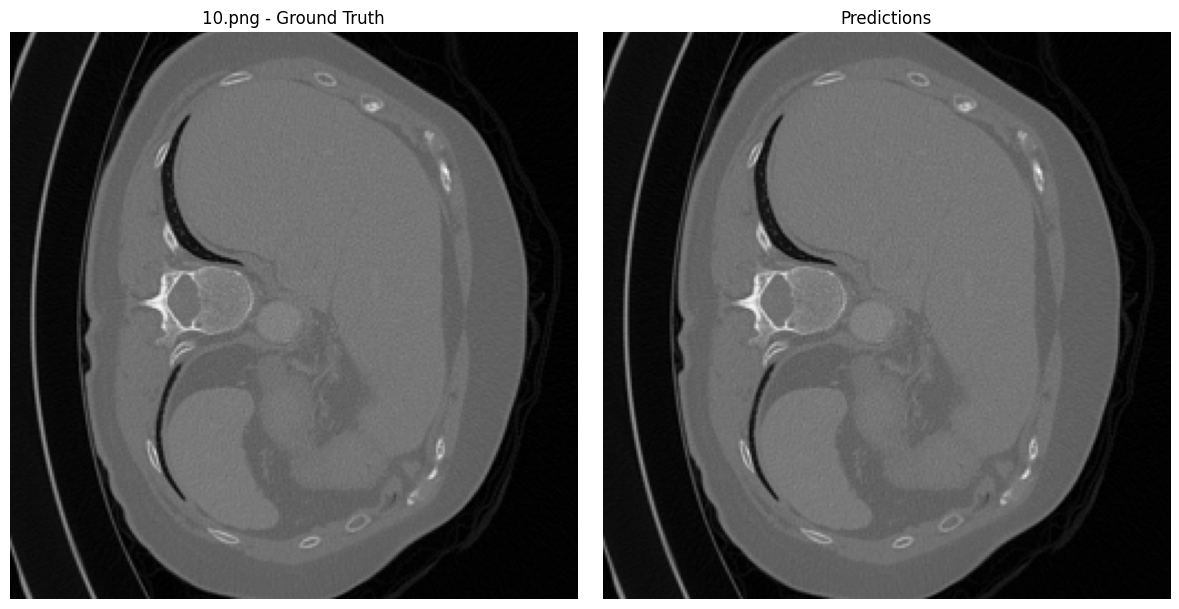

ground truth:-  130.0 47.0 140.0 60.0
predicted boundry box:-  tensor([[128.6862,  46.1469, 140.2124,  59.5891]], device='cuda:0')


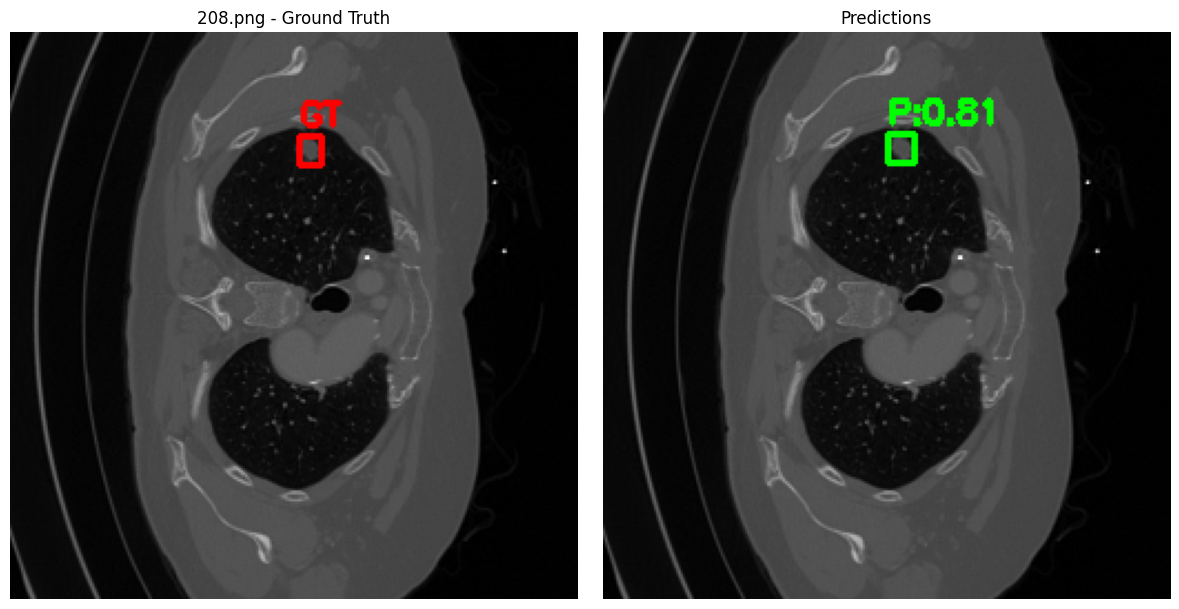

ground truth:-  132.0 51.0 138.0 60.0
predicted boundry box:-  tensor([[130.7167,  50.4839, 138.2947,  59.7288]], device='cuda:0')


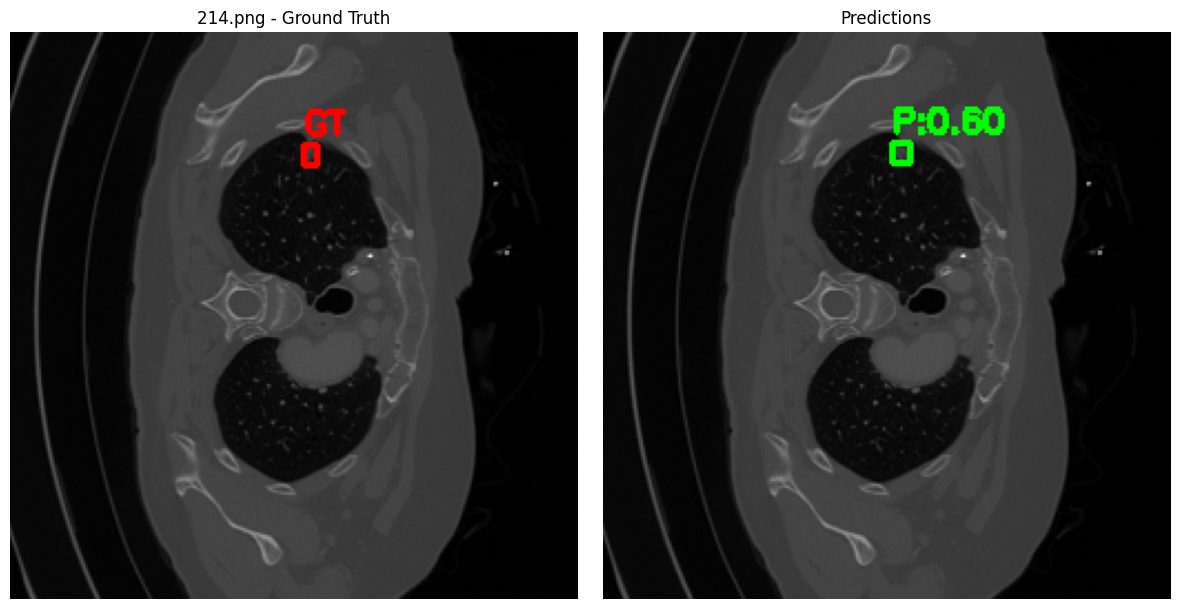

ground truth:-  133.0 51.0 139.0 56.0
predicted boundry box:-  tensor([[127.1601,  44.8919, 138.8578,  56.7345]], device='cuda:0')


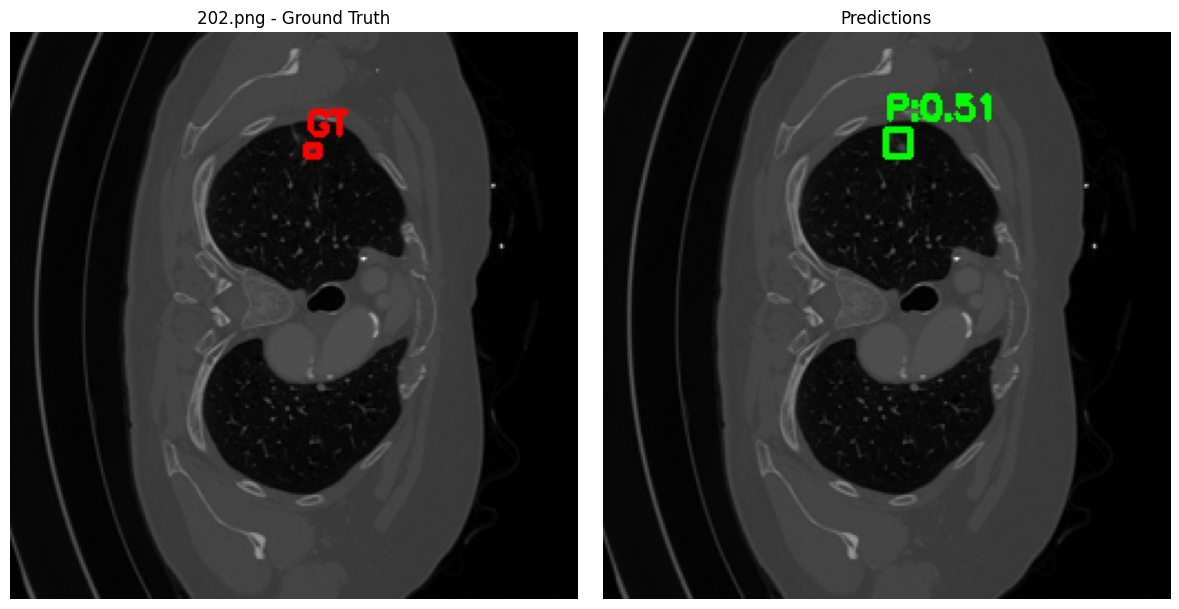

ground truth:-  131.0 53.0 138.0 59.0
predicted boundry box:-  tensor([[130.9188,  51.8355, 138.0409,  60.0599]], device='cuda:0')


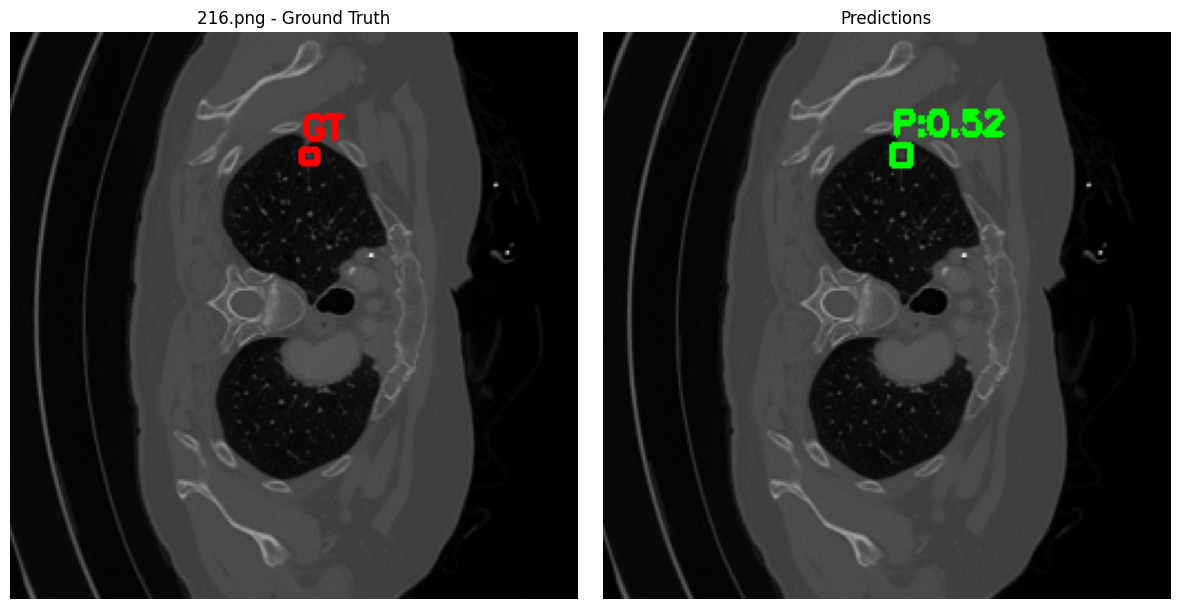

ground truth:-  129.0 47.0 139.0 56.0
predicted boundry box:-  tensor([[126.9552,  44.6738, 139.9319,  60.0987]], device='cuda:0')


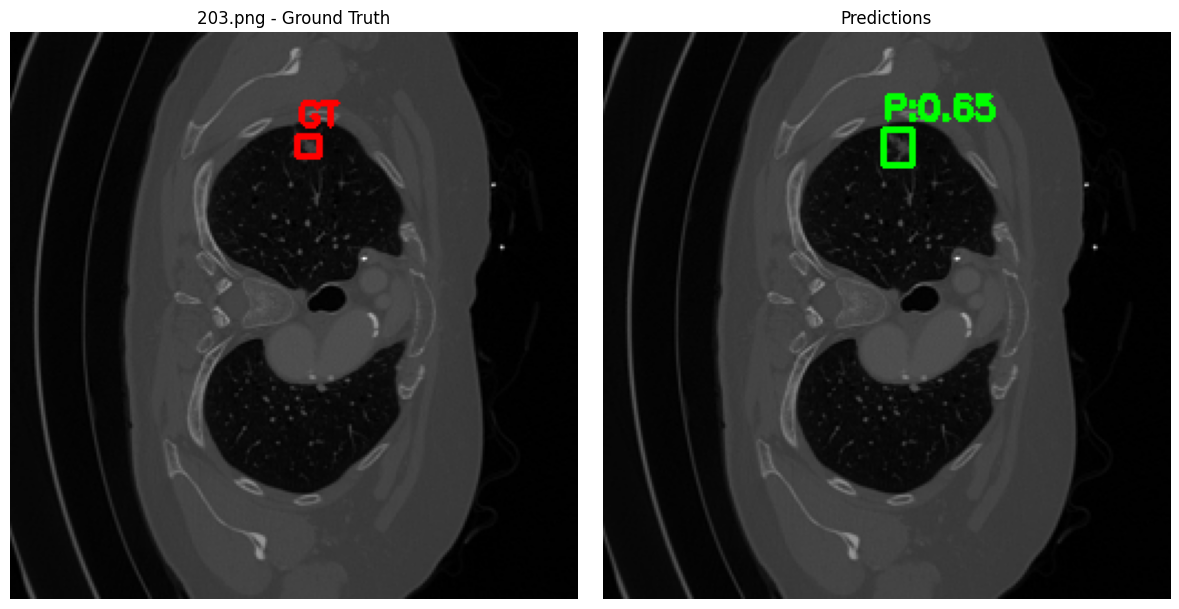

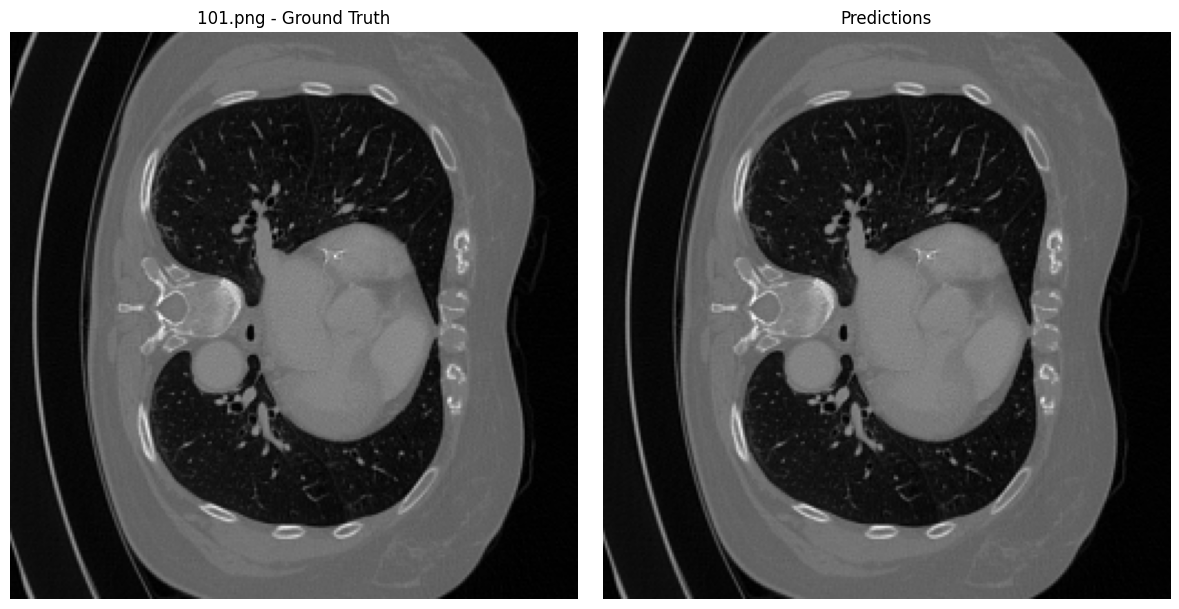

ground truth:-  130.0 50.0 140.0 59.0
predicted boundry box:-  tensor([[128.7338,  48.3058, 139.6472,  59.1754]], device='cuda:0')


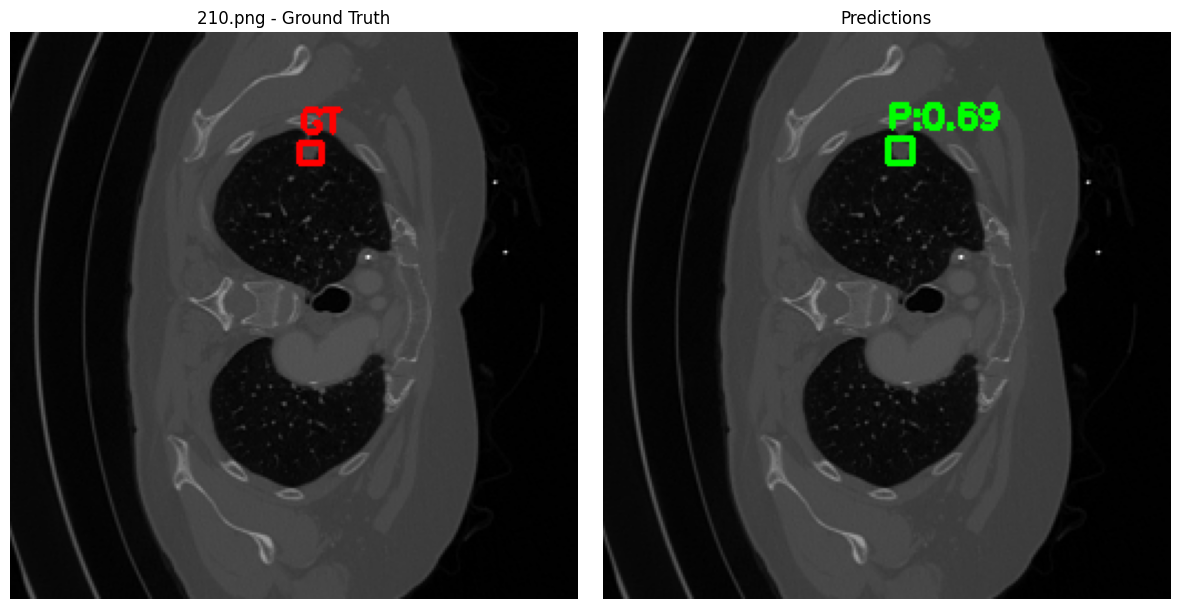

ground truth:-  132.0 51.0 139.0 56.0
ground truth:-  138.0 52.0 139.0 53.0


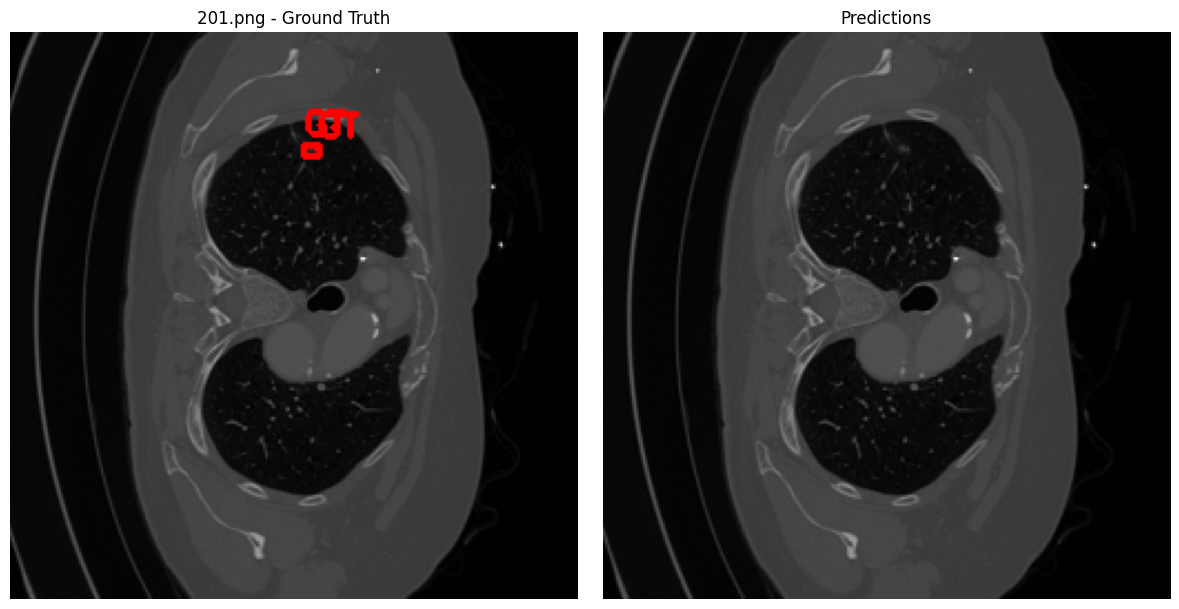

ground truth:-  131.0 51.0 139.0 59.0
predicted boundry box:-  tensor([[130.0428,  49.5369, 141.1626,  59.2352]], device='cuda:0')


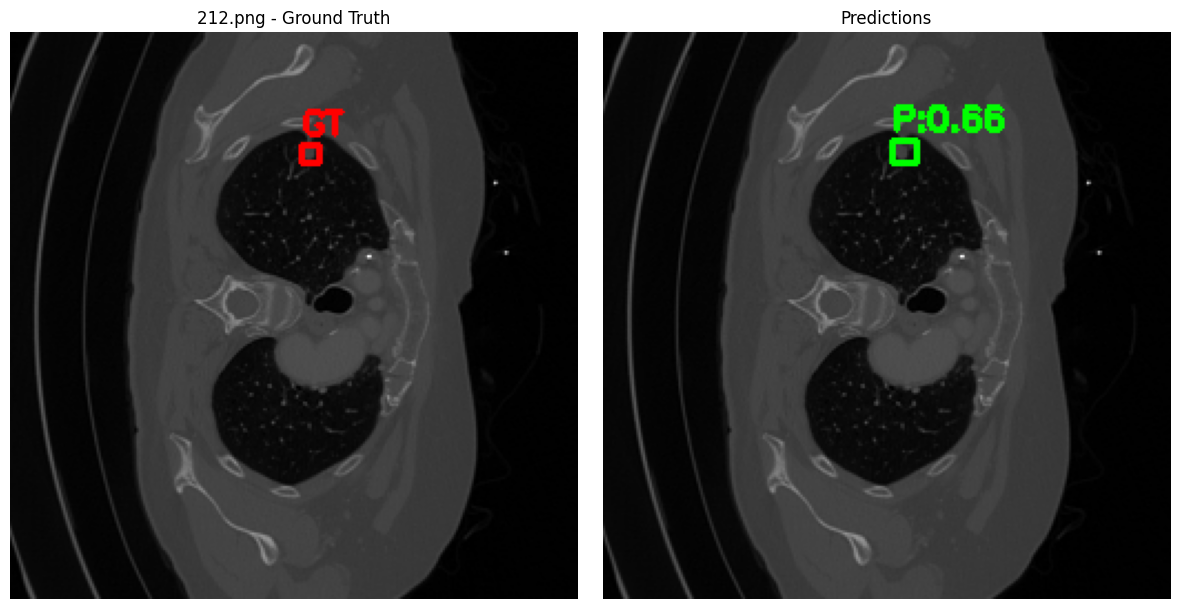

ground truth:-  131.0 47.0 139.0 60.0
ground truth:-  135.0 61.0 136.0 62.0
predicted boundry box:-  tensor([[129.1816,  46.2931, 140.8962,  61.1778]], device='cuda:0')


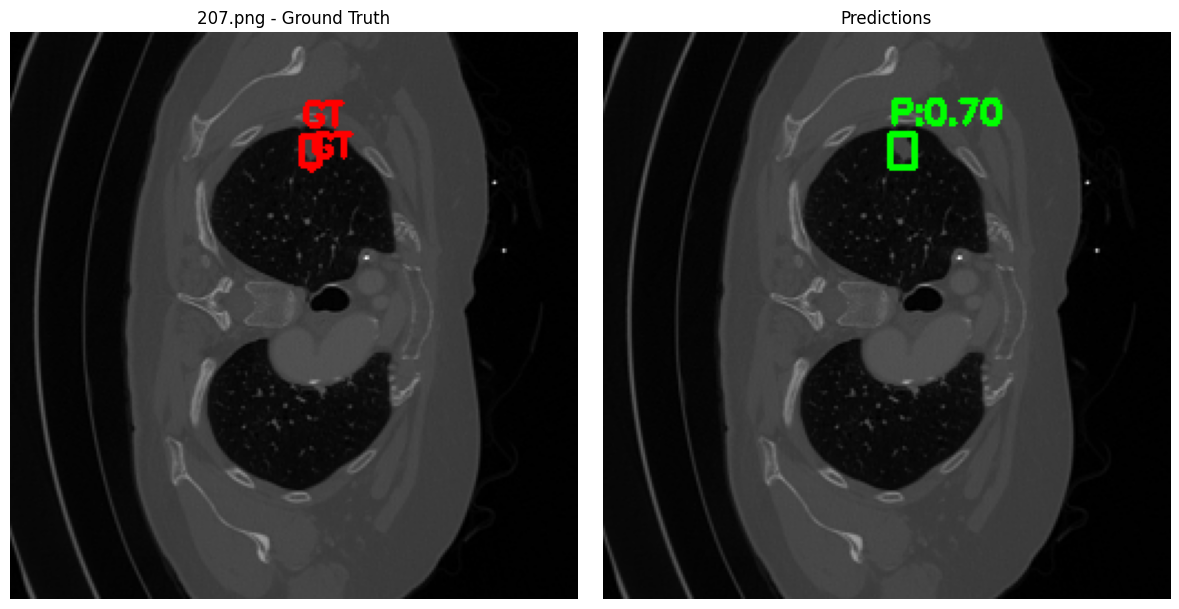

ground truth:-  131.0 48.0 140.0 59.0
predicted boundry box:-  tensor([[128.5379,  46.3215, 141.2268,  60.0353]], device='cuda:0')


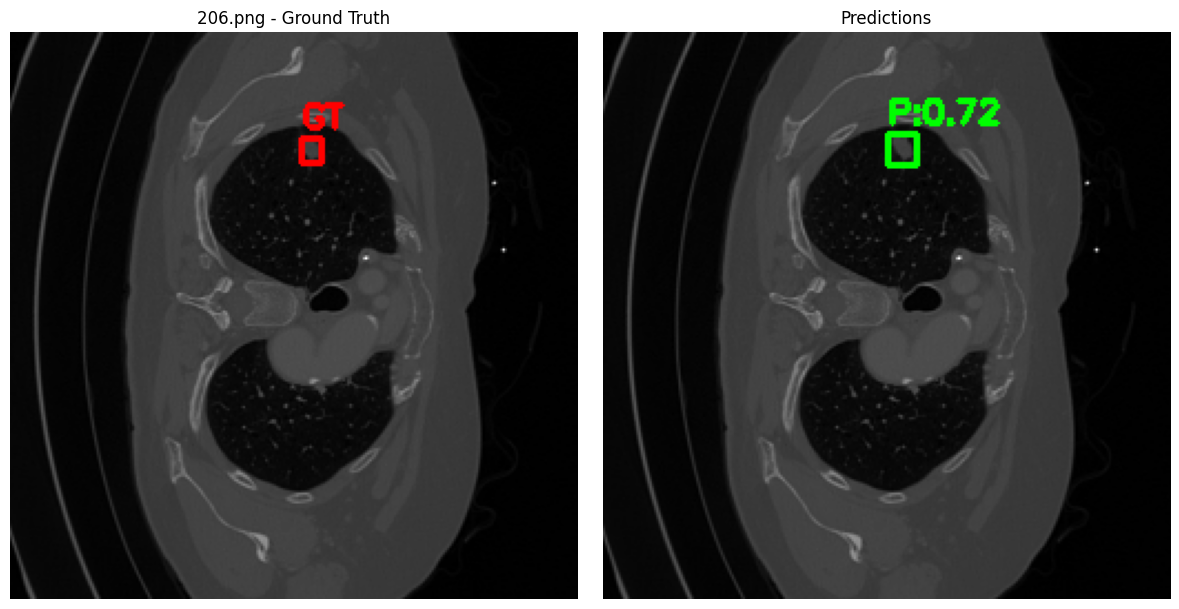

ground truth:-  130.0 47.0 140.0 58.0
predicted boundry box:-  tensor([[127.9367,  46.2360, 140.7393,  58.8675]], device='cuda:0')


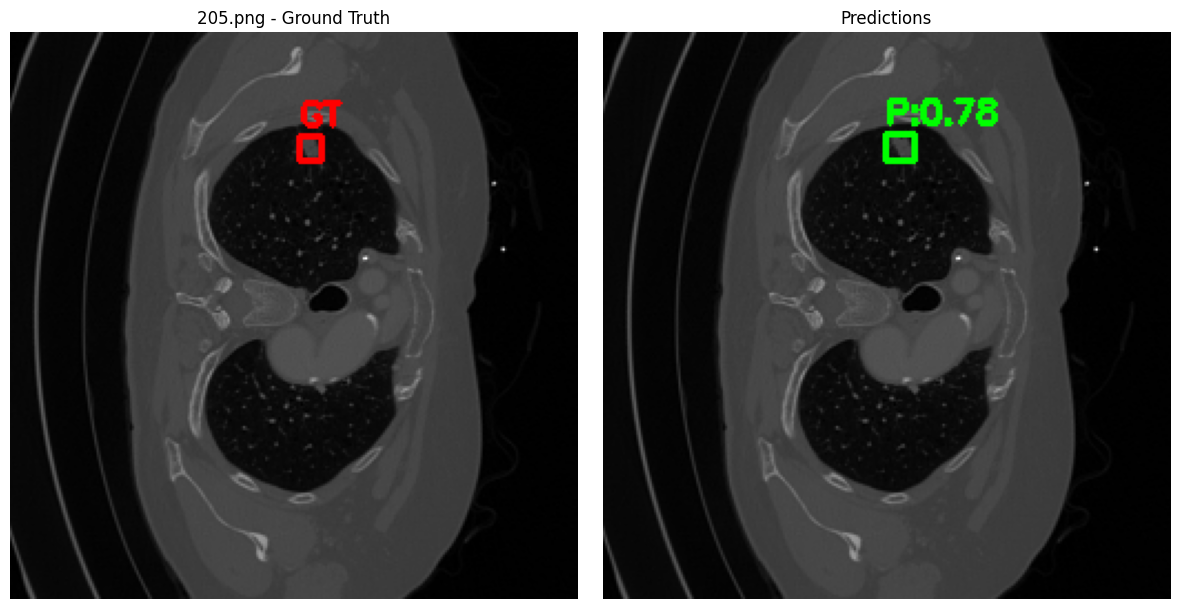

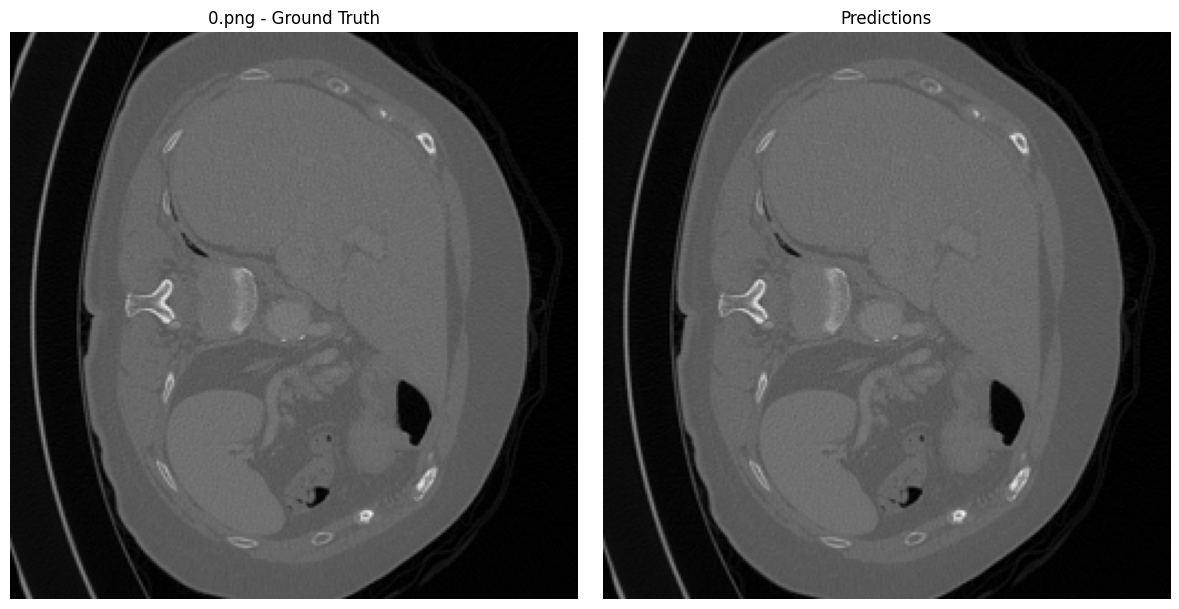

ground truth:-  131.0 53.0 139.0 59.0
predicted boundry box:-  tensor([[130.4016,  52.0431, 138.0207,  59.8837]], device='cuda:0')


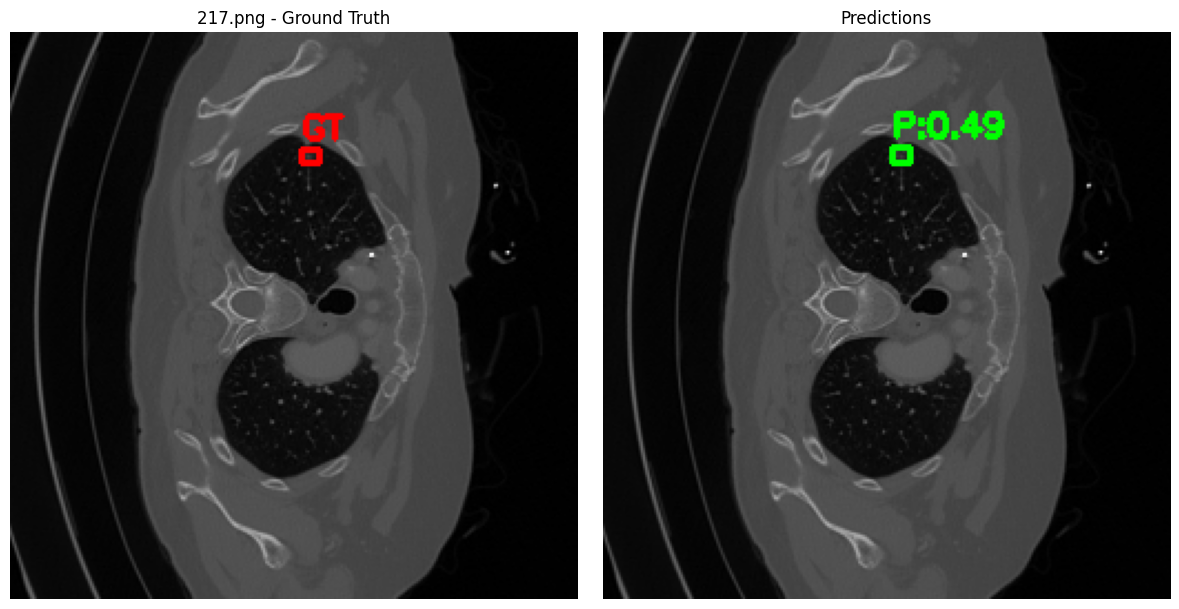

In [19]:
model = YOLO("runs/detect/train/weights/best.pt")

subject_name="Subject_57"
image_dir = Path(f"/kaggle/input/dataset/val/images/{subject_name}")
label_dir = Path(f"/kaggle/input/dataset/val/detections/{subject_name}")


image_paths = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
for img_path in image_paths:
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape


    gt_img = img.copy()
    pred_img = img.copy()


    label_path = label_dir / (img_path.stem + ".txt")

    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
               xmin,ymin,xmax,ymax= map(float, line.strip().split(','))
               print("ground truth:- ",xmin,ymin,xmax,ymax)
               draw_box(gt_img,(xmin,ymin,xmax,ymax), "GT", (255, 0, 0))


    results = model.predict(str(img_path), conf=0.3, iou=0.5, verbose=False)
    for box in results[0].boxes:
        print("predicted boundry box:- ",box.xyxy)
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf)
        draw_box(pred_img, (x1, y1, x2, y2), f"P:{conf:.2f}", (0, 255, 0))  # Green for pred


    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(gt_img)
    axs[0].set_title(f"{img_path.name} - Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(pred_img)
    axs[1].set_title("Predictions")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()
